# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

### THIS IS FOR FULL DATA AND NOT SUBSETS

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n45 = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa45_NEW.csv')
n47 = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa47_NEW.csv')
n48 = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa48_NEW.csv')

In [3]:
n_all = pd.concat([n45, n47, n48], axis = 0)

In [4]:
print(n_all.shape)

(207, 8)


In [5]:
n_all.head()

Step         L         A         x0         b  Reference Capacity  \
0   0.0  3.740389  1.753279  16.288637  0.672263            4356.636   
1   4.0  3.712603  1.729588  13.133116  0.692188            3856.567   
2   6.0  3.722015  1.738003  11.817683  0.681410            3703.252   
3   8.0  3.731969  1.766839  11.708798  0.671317            3594.173   
4  10.0  3.741630  1.762274  11.588521  0.660189            3506.276   

   Max_Temp  Ambient_Temperature  
0    15.710                  4.0  
1    16.327                  4.0  
2    16.190                  4.0  
3    16.445                  4.0  
4    16.652                  4.0

In [6]:
n_all = n_all.drop(columns = ['Ambient_Temperature', 'Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all = n_all.dropna()

In [9]:
n_all.duplicated().any()

False

In [10]:
n_all.head()

L         A         x0         b  Reference Capacity
0  3.740389  1.753279  16.288637  0.672263            4356.636
1  3.712603  1.729588  13.133116  0.692188            3856.567
2  3.722015  1.738003  11.817683  0.681410            3703.252
3  3.731969  1.766839  11.708798  0.671317            3594.173
4  3.741630  1.762274  11.588521  0.660189            3506.276

In [11]:
n_all.tail()

L         A         x0         b  Reference Capacity
63  4.053143  1.367157  90.792453  0.425636            4679.544
64  3.761847  1.062848  29.368878  0.507540            4568.834
65  3.198999  0.508999   0.308223  5.962126            4519.852
66  3.190154  0.506154   7.791413  3.232986            4507.155
67  3.207044  0.517044   7.870066  3.238898            4403.258

In [12]:
n_all.describe()

L           A          x0           b  Reference Capacity
count  207.000000  207.000000  207.000000  207.000000          207.000000
mean     3.916499    1.535008   52.673352    0.578974         4099.555184
std      0.205468    0.251565   39.083055    0.487567          867.215342
min      3.190154    0.506154    0.308223    0.324807         2678.509000
25%      3.763128    1.425090   13.555841    0.393171         3127.438500
50%      3.922227    1.531165   50.690477    0.451044         4359.665000
75%      4.115015    1.769144   81.421121    0.714408         4654.944500
max      4.198013    1.810901  155.908557    5.962126         6134.145000

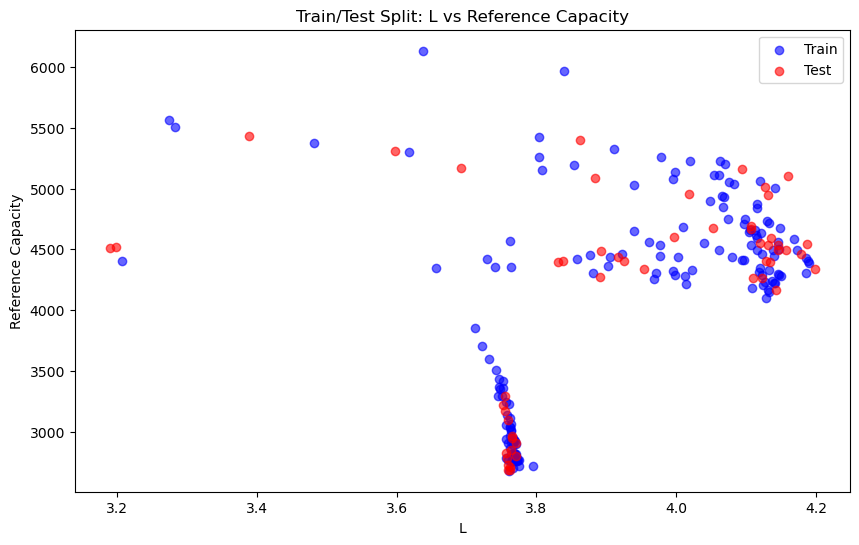

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [14]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(155, 4) (155,)

 (52, 4) (52,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [367.9774887717368, 342.81559666812404, 2810.465928455578, 371.2895597627313, 364.74898844479634]
  MAE (folds): [284.8641554160062, 284.83757415260555, 696.803791090166, 291.4615922580092, 262.7057325204512]
  Average RMSE: 851.4595
  Average MAE: 364.1346
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [367.7140047359338, 342.7529156182541, 2043.8064875217317, 372.7480619166362, 362.0920957790623]
  MAE (folds): [283.40012452186073, 286.74154529517494, 570.8968402731597, 291.48689265069663, 260.59668898354755]
  Average RMSE: 697.8227
  Average MAE: 338.6244
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [367.94604213579726, 342.89886172485046, 2802.871958944838, 371.38458826167937, 364.67074915002354]
  MAE (folds): [284.6632085904369, 284.9472893840072, 695.3282819480567, 291.3850646346994, 262.5067924436607]
  Average RMSE: 849.9544
  Avera

In [17]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [18]:
models['Elastic Net'].coef_

array([ -40.34872756, -588.37493661,  227.78987957, -269.60377109])

In [19]:
# x0 most weight in model
# these values might be because of the regularization
# but the features were scaled!

In [20]:
models['Elastic Net'].intercept_

4086.6418071563376

In [21]:
X_train_scaled

array([[-7.71060709e-01,  9.44500969e-01, -1.02692797e+00,
         5.93671565e-01],
       [-8.10438308e-01,  9.37995890e-01, -1.04380052e+00,
         7.21186469e-01],
       [-8.10498587e-01,  1.03067754e+00, -1.00455746e+00,
         7.81857084e-01],
       [ 1.00588903e+00,  3.63965699e-01,  7.32146753e-01,
        -5.83380453e-01],
       [ 1.39467946e+00, -1.92265660e-01,  1.76029638e+00,
        -5.76212476e-01],
       [ 7.58632230e-01, -6.99252023e-01,  1.06884197e+00,
        -6.01880577e-01],
       [-8.88372088e-01,  9.40592135e-01, -1.06657181e+00,
         4.39003670e-01],
       [ 4.91003660e-01, -1.36588083e-01,  2.41684994e-02,
        -3.55459001e-01],
       [-8.03451481e-01,  9.46158573e-01, -1.01291602e+00,
         7.56944388e-01],
       [ 4.84344450e-01, -1.20773422e-01,  3.10614657e-02,
        -3.75822009e-01],
       [ 1.12925393e+00,  4.10176193e-01,  6.25762241e-01,
        -4.77629470e-01],
       [ 7.83381803e-01, -7.12599421e-01,  1.69374786e+00,
      

In [22]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [804.642720859882, 935.0478119378877, 842.2983382858689, 947.7167893486227, 881.0669475360484]
  MAE (folds): [597.8536858485752, 735.2870645840123, 654.2128347594621, 743.544025323963, 712.528716427945]
  Average RMSE: 882.1545
  Average MAE: 688.6853
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [220.65334335032742, 270.47706651485976, 295.7480024947134, 359.54418712191875, 260.3095220299318]
  MAE (folds): [121.13116129032262, 161.6548064516129, 168.10329032258073, 178.01632258064515, 163.71293548387104]
  Average RMSE: 281.3464
  Average MAE: 158.5237
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [250.15030169460576, 160.04888416661254, 211.99403509800837, 295.47555745807495, 233.65485331937398]
  MAE (folds): [115.70126419354759, 108.48511258064475, 133.27241032258033, 128.7030170967746, 156.67560225806434]
  Average RMSE: 230.2647
  Average

In [23]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [219.76790918542943, 262.4456988921552, 253.34331542816395, 369.8120864906304, 274.4714906722336]
  MAE (folds): [129.37169877112126, 156.31771267281118, 152.47979961597528, 186.95159669738874, 176.9640339477727]
  Average RMSE: 275.9681
  Average MAE: 160.4170
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [251.25169386670655, 148.97061659343245, 199.313175359021, 290.72948560593704, 234.02974593198442]
  MAE (folds): [118.94638645161275, 102.44122967741893, 131.98875870967694, 129.06261806451616

In [24]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [25]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [26]:
import numpy as np

In [27]:
# numbers from previous avg. % diff. values for one cell 4, 8, 11, 31?
# these were transformed by mult. them by 0.10
# then used in np.random.normal for standard devs.
# this creates noisy data and helps to access how robust the model is

In [28]:
xnew = X_test*np.random.normal([1,1,1,1],[.04,.08,.11,.31])

In [29]:
xnew - X_test

L         A        x0         b
22 -0.293542 -0.137311  4.586499 -0.062023
15 -0.268208 -0.173103  0.598584 -0.116406
3  -0.242230 -0.089938  0.453999 -0.114080
26 -0.296294 -0.160421  4.234291 -0.064473
27 -0.295277 -0.140451  4.939498 -0.063630
9  -0.268416 -0.174612  0.597295 -0.111416
30 -0.295087 -0.159653  3.637988 -0.065967
65 -0.274300 -0.131750  1.662646 -0.082345
18 -0.268695 -0.172252  0.614934 -0.115246
9  -0.297314 -0.143130  7.673607 -0.053627
32 -0.293544 -0.138777  5.800774 -0.061591
30 -0.269542 -0.173124  0.654995 -0.114877
16 -0.295222 -0.141548  5.940166 -0.056163
66 -0.227987 -0.049242  0.383483 -0.526782
55 -0.282547 -0.141906  2.192066 -0.074122
57 -0.273741 -0.111333  1.686301 -0.079313
25 -0.295590 -0.141268  5.041159 -0.062678
50 -0.294617 -0.139654  4.624823 -0.067260
14 -0.277612 -0.135581  2.110059 -0.066173
5  -0.257160 -0.109777  0.805605 -0.082868
54 -0.280491 -0.140663  2.146713 -0.076036
31 -0.298651 -0.145533  5.852683 -0.063287
34 -0.285657 -0.148769  2.505182 -0.069004
31 -0.295459 -0.161326  3.782451 -0.066930
69 -0.268849 -0.174537  0.666304 -0.127120
25 -0.269109 -0.173511  0.620459 -0.118234
25 -0.294485 -0.158154  3.786861 -0.064776
16 -0.268390 -0.173127  0.594750 -0.116565
2  -0.276033 -0.115427  2.992280 -0.057323
45 -0.300014 -0.146125  6.018462 -0.064530
15 -0.294940 -0.139997  6.427098 -0.055255
68 -0.268857 -0.173500  0.669732 -0.126604
66 -0.268600 -0.172744  0.675871 -0.129939
50 -0.296069 -0.161576  3.690239 -0.068809
8  -0.292622 -0.137134  6.087081 -0.053372
28 -0.296291 -0.161585  4.124131 -0.065552
68 -0.278064 -0.135413  1.816938 -0.079539
28 -0.299255 -0.146062  6.256290 -0.062051
45 -0.269536 -0.172989  0.664080 -0.118053
43 -0.293702 -0.159328  3.248691 -0.068109
65 -0.268476 -0.173446  0.698157 -0.133138
38 -0.297115 -0.142082  5.486518 -0.063729
16 -0.287218 -0.148948  3.227945 -0.061820
63 -0.289661 -0.133005  4.468681 -0.069353
67 -0.268659 -0.172414  0.662898 -0.129946
12 -0.263918 -0.118103  1.275982 -0.077589
65 -0.228619 -0.049518  0.015170 -0.971467
54 -0.278207 -0.116732  2.158278 -0.073614
38 -0.269020 -0.173268  0.650161 -0.122338
24 -0.269078 -0.172986  0.618529 -0.117223
60 -0.268644 -0.173475  0.693344 -0.127493
55 -0.279901 -0.120205  2.211845 -0.073521

In [30]:
xnew = scaler.transform(xnew)

In [31]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([5284.64061, 4536.1555 , 5118.75611, 5143.34864, 5263.46234,
       4557.183  , 5118.55332, 5543.20374, 4556.57299, 5250.12755,
       5272.89526, 4549.10811, 5257.0365 , 4839.48752, 5352.83921,
       5554.36571, 5260.57552, 5242.7943 , 5511.52524, 5494.51676,
       5610.45671, 5218.72506, 5275.0669 , 5121.07174, 4537.3297 ,
       4535.66665, 5139.85875, 4536.1555 , 5557.33733, 5217.68944,
       5259.83832, 4537.3297 , 4537.3297 , 5120.15142, 5289.03919,
       5121.67495, 5525.37788, 5221.13525, 4537.3297 , 5128.25279,
       4480.01591, 5263.04559, 5261.9153 , 5290.18788, 4537.3297 ,
       5597.92914, 5007.17081, 5588.68454, 4535.66665, 4535.66665,
       4555.39807, 5699.42222])

In [32]:
testpred

array([4695.11596, 3307.04442, 5217.47705, 4461.45331, 4560.22714,
       3221.97309, 4283.11082, 4515.89618, 3104.20147, 4888.14826,
       4706.73622, 2846.3867 , 4961.59647, 4944.30359, 4344.95308,
       4600.31389, 4567.03501, 4383.82951, 4728.51563, 5205.00315,
       4348.99605, 4504.2857 , 4489.76753, 4250.68829, 2801.49347,
       3012.43116, 4570.47095, 3161.81765, 5412.78276, 4406.61929,
       4928.99201, 2811.49495, 2807.09522, 4215.68395, 4944.49563,
       4313.96109, 4467.4509 , 4561.39605, 2825.92122, 4321.10891,
       2841.43788, 4466.96864, 4957.61203, 4907.95839, 2803.97584,
       4614.23871, 5007.17081, 4457.09129, 2848.94339, 3027.20601,
       2797.6754 , 4453.33978])

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

In [34]:
mean_absolute_percentage_error(testpred, testprednew)

0.26257285448482154

DecisionTreeRegressor(random_state=42) 186.37738896983058
RandomForestRegressor(random_state=42) 161.74671795088466
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 209.90167506801265


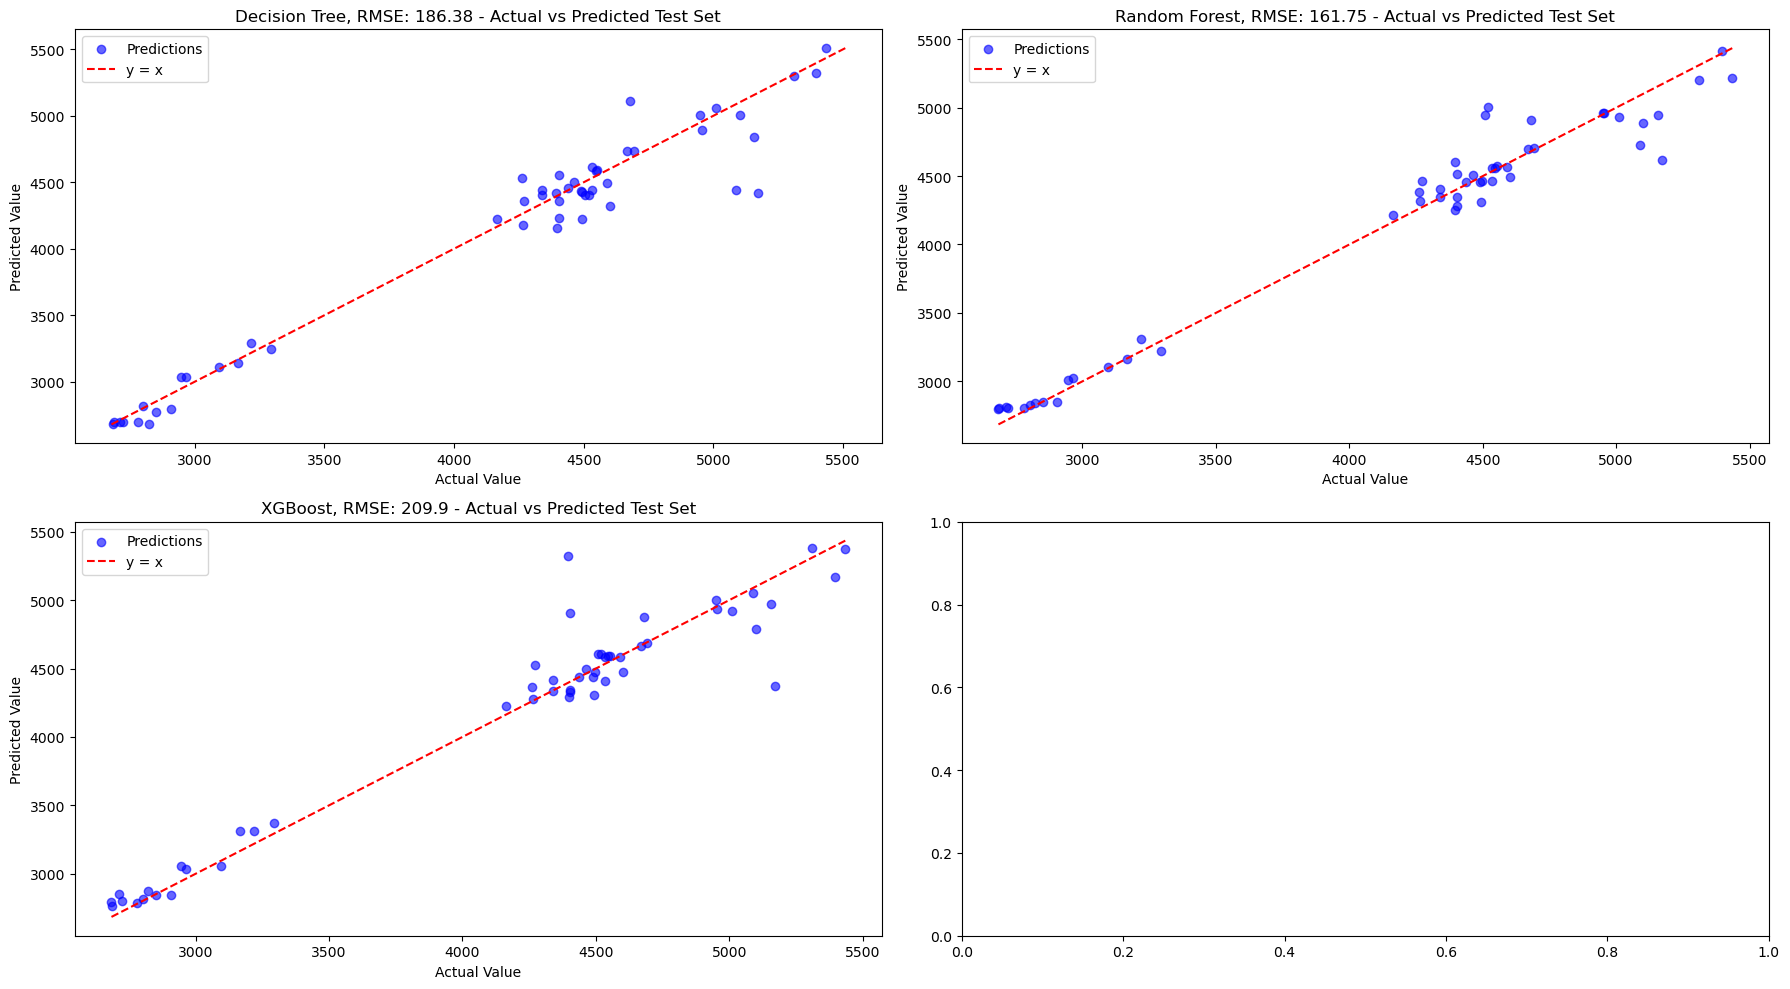

In [35]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [36]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 4.49%
Random Forest - Percentage RMSE: 3.90%
XGBoost - Percentage RMSE: 5.06%


In [37]:
features

['L', 'A', 'x0', 'b']

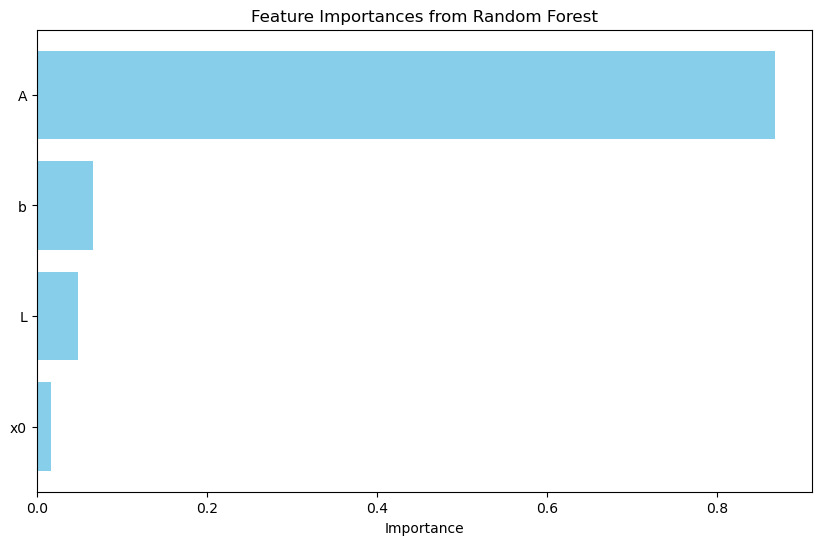

In [38]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

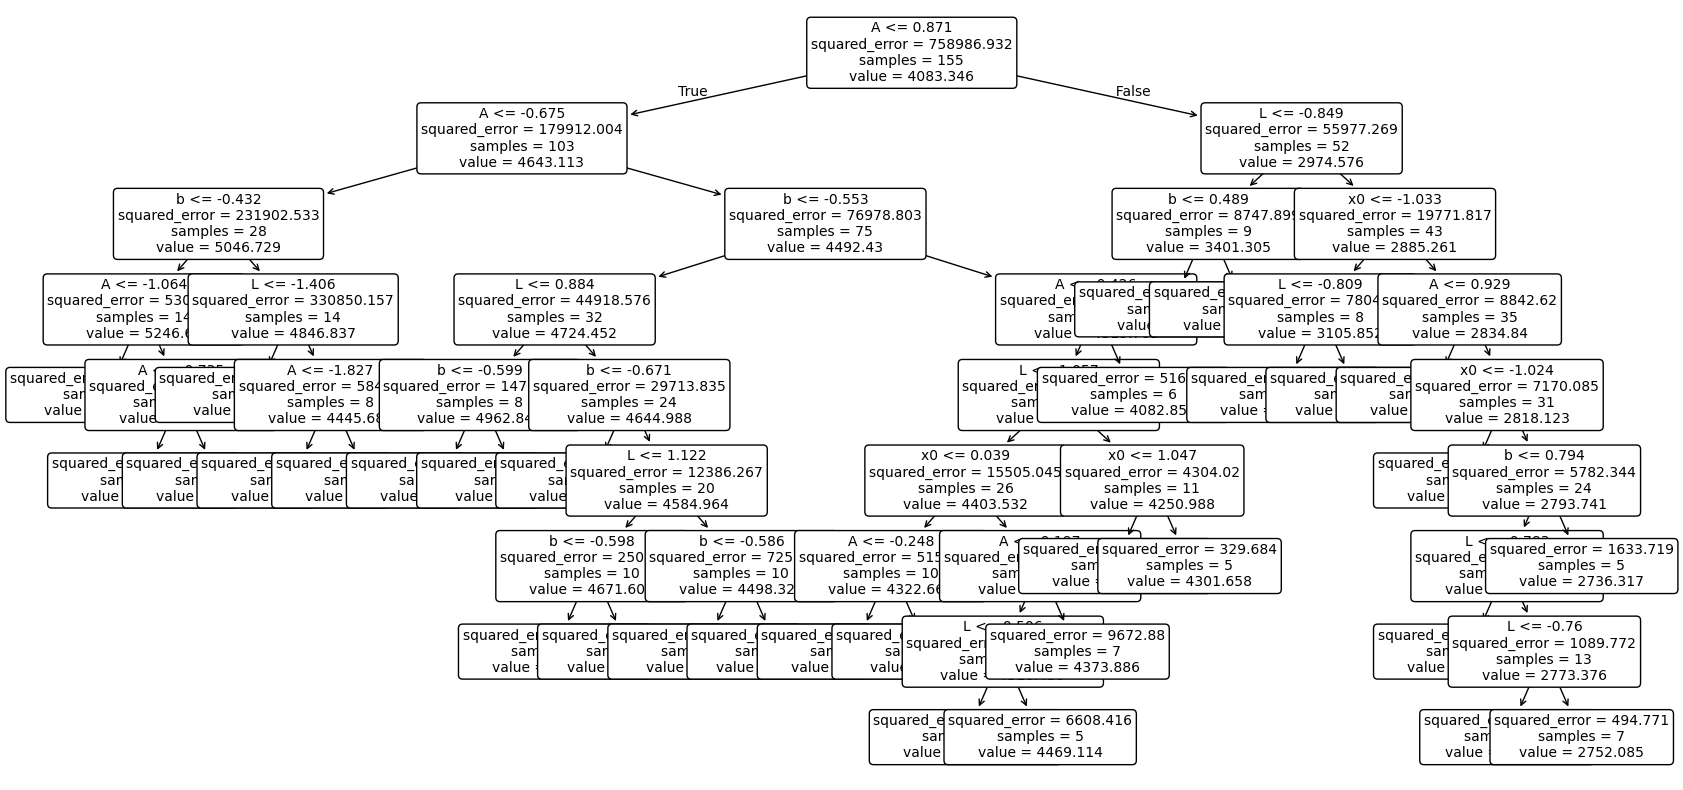

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

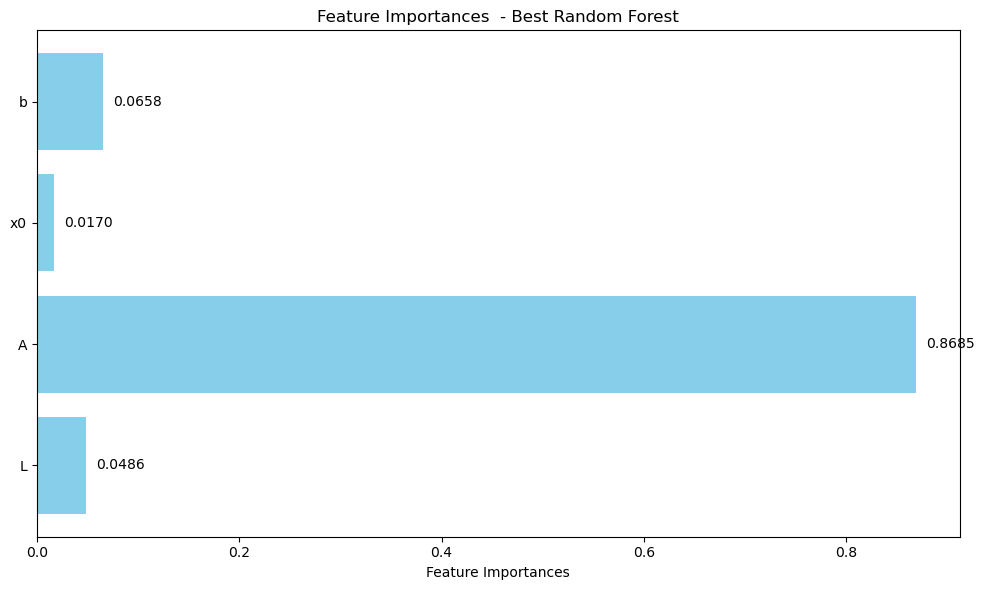

In [40]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()